# V01 - Proyecto Parte 3

En esta parte del proyecto se continuará con una actualización del 'Proyecto Parte 2', agregando correcciones, mejoras o simples actualizaciones. Este proyecto se dividirá en las siguientes secciones:

## **Puesta al día**

Se volverán a cargar los datos y se realizarán todos los pasos de transformación aplicados en la Parte 2, sin detallar el proceso (ya fue explicado en 'Proyecto Parte 2'):
Este paso fue realizado en el 'Poryecto Parte 3':
- En este paso no solo se descartarán las observaciones con operaciones realizadas desde las 14 horas en adelante, en su lugar solo se tomarán las operaciones realizadas desde las 2am hasta las 14 pm
- **Paso 6:** Eliminamos las columnas que no tomaremos en cuenta `['spread','real_volume','Year','Buy']`
- **Paso 7:** Agregamos las columnas caracteristicas RSI Y ATR de 14 periodos
- **Paso 8:** Agregamos los máximos y minimos como columnas caracteristicas
- **Paso 9:** Guardamos los datos en un archivo .csv
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Continuación**

Inicio del **Proyecto Parte 3**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#------------------------------------------------------------------------------------------------------------------
#| Esta celda solo se debe ejecutar si es la primera vez que se revisa este proyecto, sino, pasar a la siguiente. |
#------------------------------------------------------------------------------------------------------------------

'''#Load data
data=pd.read_csv('../Datos/US30.cash_data_m1_antiguo.csv',index_col=0,parse_dates=True)
#-----------------------------------------PASO 1-----------------------------------------

data.index=data.index.tz_localize('Etc/GMT-3')#Localizamos el horario en el que se encuentran los datos en MetaTrader5
data.index=data.index.tz_convert('Etc/GMT+5').tz_localize(None)# Al final eliminamos la zona horaria del índice

data['Year'] = data.index.year#Creamos una columna con el año del índice
data['DayOfYear'] = data.index.dayofyear#Creamos una columna con el dia del año del índice
data['Hour']=data.index.hour#Creamos una columna con la hora del índice
data['Minute']=data.index.minute#Creamos una columna con los minutos del índice

#-----------------------------------------PASO 2-----------------------------------------
data = data[~data['DayOfYear'].isin([data['DayOfYear'].min(),
                                     data['DayOfYear'].max()])]

#-----------------------------------------PASO 3-----------------------------------------

# Al solo procesar las columnas seleccionadas, la función optimiza el rendimiento, especialmente útil para DataFrames grandes.
def agregar_columnas_operaciones(df, Tres=False, Dos=False, PuntoCinco=False):
    """
    Agrega columnas de operaciones al DataFrame basado en los parámetros seleccionados.

    Parámetros:
    - df (pd.DataFrame): DataFrame original que contiene las columnas necesarias.
    - Tres (bool): Si es True, agrega y calcula la columna 'Tres'.
    - Dos (bool): Si es True, agrega y calcula la columna 'Dos'.
    - PuntoCinco (bool): Si es True, agrega y calcula la columna 'PuntoCinco'.

    Retorna:
    - pd.DataFrame: DataFrame con las nuevas columnas agregadas según los parámetros.
    """
    
    # Asegurarse de que el DataFrame esté ordenado cronológicamente
    df = df.sort_values(by=['DayOfYear', 'Hour', 'Minute']).reset_index(drop=True)
    
    # Inicializar las nuevas columnas con NaN según los parámetros
    columnas_a_agregar = {}
    if Tres:
        df['Tres'] = np.nan
        columnas_a_agregar['Tres'] = 3
    if Dos:
        df['Dos'] = np.nan
        columnas_a_agregar['Dos'] = 2
    if PuntoCinco:
        df['PuntoCinco'] = np.nan
        columnas_a_agregar['PuntoCinco'] = 1.5
    
    # Si no se seleccionó ninguna columna, retornar el DataFrame original
    if not columnas_a_agregar:
        print("No se seleccionó ninguna columna para agregar.")
        return df
    
    # Definir los factores de multiplicación para las columnas seleccionadas
    factores = columnas_a_agregar
    
    # Convertir las columnas de tiempo a minutos totales para facilitar cálculos
    df['TotalMinutes'] = df['DayOfYear'] * 1440 + df['Hour'] * 60 + df['Minute']
    
    n = len(df)
    
    # Iterar sobre cada fila del DataFrame
    for i in range(n):
        buy = df.at[i, 'Buy']
        open_price = df.at[i, 'open']
        day = df.at[i, 'DayOfYear']
        time = df.at[i, 'TotalMinutes']
        
        # Parámetros fijos
        StopLoss = 30
        
        # Para cada columna a calcular
        for col, factor in factores.items():
            if pd.notna(df.at[i, col]):
                continue  # Ya procesado
            
            # Calcular SL_price y TP_price
            if buy == 1:
                SL_price = open_price - StopLoss
                TP_price = open_price + StopLoss * factor
            else:
                SL_price = open_price + StopLoss
                TP_price = open_price - StopLoss * factor
            
            # Buscar en las observaciones siguientes
            j = i + 1
            operacion_cerrada = False
            while j < n:
                # Verificar cambio de día o tiempo máximo de 60 minutos
                current_day = df.at[j, 'DayOfYear']
                current_time = df.at[j, 'TotalMinutes']
                elapsed_time = current_time - time
                if current_day != day or elapsed_time >= 60:
                    # Operación cerrada por tiempo, se considera pérdida
                    df.at[i, col] = 0
                    operacion_cerrada = True
                    break
                
                high = df.at[j, 'high']
                low = df.at[j, 'low']
                
                if buy == 1:
                    if high >= TP_price:
                        df.at[i, col] = 1  # Ganó
                        operacion_cerrada = True
                        break
                    elif low <= SL_price:
                        df.at[i, col] = 0  # Perdió
                        operacion_cerrada = True
                        break
                else:
                    if low <= TP_price:
                        df.at[i, col] = 1  # Ganó
                        operacion_cerrada = True
                        break
                    elif high >= SL_price:
                        df.at[i, col] = 0  # Perdió
                        operacion_cerrada = True
                        break
                j += 1
            
            if not operacion_cerrada:
                # Si no se cerró la operación dentro del DataFrame, se considera pérdida
                df.at[i, col] = 0
    
    # Eliminar la columna temporal 'TotalMinutes'
    df.drop(columns=['TotalMinutes'], inplace=True)
    
    return df

data=data[~data['Hour'].isin(list(range(17,24)))].copy() #Eliminamos los datos de las 16hs en adelante )
# Creamos los DataFrames de Buys y Sells
Buys=data.copy()
Sells=data.copy()
Buys['Buy']=1
Sells['Buy']=0
Buys = agregar_columnas_operaciones(Buys,True)#Agregamos las columnas de operaciones
Sells = agregar_columnas_operaciones(Sells,True)

#-----------------------------------------PASO 4-----------------------------------------

Buys=Buys[Buys['Hour'].isin(list(range(2,15)))].copy() #Solo tomamos las operaciones entre las 2hs y las 15hs
Sells=Sells[Sells['Hour'].isin(list(range(2,15)))].copy() #Solo tomamos las operaciones entre las 2hs y las 15hs

#-----------------------------------------PASO 5-----------------------------------------

Buys.to_csv('Buys.csv', index=False)#Guardamos los datos en un archivo csv
Sells.to_csv('Sells.csv', index=False)

#-----------------------------------------PASO 6-----------------------------------------
Buys=Buys.drop(['spread','real_volume','Year','Buy'],axis=1).copy() #Eliminamos las columnas que no necesitamos
Sells=Sells.drop(['spread','real_volume','Year','Buy'],axis=1).copy() #Eliminamos las columnas que no necesitamos

#-----------------------------------------PASO 7-----------------------------------------
def agregar_atr_rsi(df, periodo_atr, periodo_rsi):
    """
    Agrega columnas ATR y RSI al DataFrame, calculadas por día del año.

    Parámetros:
    - df: pandas DataFrame con columnas ['open', 'high', 'low', 'close', 'tick_volume', 
                                         'DayOfYear', 'Hour', 'Minute', 'Tres']
    - periodo_atr: int, el período para calcular el ATR
    - periodo_rsi: int, el período para calcular el RSI

    Retorna:
    - pandas DataFrame con nuevas columnas 'ATR{periodo_atr}' y 'RSI{periodo_rsi}'
    """
    # Asegurar que el DataFrame está ordenado correctamente
    df = df.sort_values(['DayOfYear', 'Hour', 'Minute', 'Tres']).reset_index(drop=True)

    ### Cálculo del ATR ###

    # Calcular el Close anterior por día
    df['prev_close'] = df.groupby('DayOfYear')['close'].shift(1)

    # Calcular el True Range (TR)
    df['TR'] = df.apply(
        lambda row: max(
            row['high'] - row['low'],
            abs(row['high'] - row['prev_close']) if not pd.isna(row['prev_close']) else row['high'] - row['low'],
            abs(row['low'] - row['prev_close']) if not pd.isna(row['prev_close']) else row['high'] - row['low']
        ),
        axis=1
    )

    # Definir el nombre de la nueva columna ATR
    atr_column = f'ATR{periodo_atr}'

    # Calcular el ATR como media móvil simple del TR por grupo (día)
    df[atr_column] = df.groupby('DayOfYear')['TR'].transform(
        lambda x: x.rolling(window=periodo_atr, min_periods=periodo_atr).mean()
    )

    # Reemplazar los valores NaN (primeras observaciones) por 0
    df[atr_column] = df[atr_column].fillna(0)

    # Redondear el ATR para mayor claridad
    df[atr_column] = df[atr_column].round(4)

    ### Cálculo del RSI ###

    # Definir el nombre de la nueva columna RSI
    rsi_column = f'RSI{periodo_rsi}'

    # Definir la función calculate_rsi dentro del ámbito para acceder a 'periodo_rsi'
    def calculate_rsi(close_series):
        delta = close_series.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        # Usar EMA para promedio de ganancias y pérdidas
        avg_gain = gain.ewm(alpha=1/periodo_rsi, min_periods=periodo_rsi, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/periodo_rsi, min_periods=periodo_rsi, adjust=False).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        # Reemplazar NaN iniciales por 0
        rsi = rsi.fillna(0)

        return rsi

    # Calcular el RSI por grupo (día), seleccionando sólo la columna 'close'
    df[rsi_column] = df.groupby('DayOfYear', group_keys=False)['close'].apply(calculate_rsi)

    # Redondear el RSI para mayor claridad
    df[rsi_column] = df[rsi_column].round(2)

    # Eliminar columnas auxiliares
    df = df.drop(columns=['prev_close', 'TR'])

    return df

Buys=agregar_atr_rsi(Buys,14,14) #Agregamos la columna ATR
Sells=agregar_atr_rsi(Sells,14,14) #Agregamos la columna ATR

#-----------------------------------------PASO 8-----------------------------------------
def agregar_max_min(df, n):
    """
    Agrega las columnas 'maximo' y 'minimo' al DataFrame.
    
    Parámetros:
    - df (pd.DataFrame): DataFrame que contiene las columnas ['open', 'high', 'low', 'close'].
    - n (int): Número de observaciones anteriores y posteriores a considerar.
    
    Retorna:
    - pd.DataFrame: DataFrame original con las columnas 'maximo' y 'minimo' agregadas.
    """
    # Asegurarse de que el DataFrame está ordenado correctamente (opcional)
    # df = df.sort_index()

    # Calcular el máximo en una ventana de 2n+1 centrada en cada observación
    rolling_max = df['high'].rolling(window=2*n+1, center=True).max()
    # Asignar 1 si el 'high' actual es igual al máximo de la ventana, de lo contrario 0
    df['maximo'] = (df['high'] == rolling_max).astype(int)
    
    # Calcular el mínimo en una ventana de 2n+1 centrada en cada observación
    rolling_min = df['low'].rolling(window=2*n+1, center=True).min()
    # Asignar 1 si el 'low' actual es igual al mínimo de la ventana, de lo contrario 0
    df['minimo'] = (df['low'] == rolling_min).astype(int)
    
    # Opcional: Reemplazar NaN en las primeras y últimas n filas con 0
    df['maximo'] = df['maximo'].fillna(0).astype(int)
    df['minimo'] = df['minimo'].fillna(0).astype(int)
    
    return df

Buys=agregar_max_min(Buys,4)
Sells=agregar_max_min(Sells,4)

#-----------------------------------------PASO 9-----------------------------------------
Buys.to_csv('Buys.csv', index=False)#Guardamos los datos en un archivo csv
Sells.to_csv('Sells.csv', index=False)'''

'#Load data\ndata=pd.read_csv(\'../Datos/US30.cash_data_m1_antiguo.csv\',index_col=0,parse_dates=True)\n#-----------------------------------------PASO 1-----------------------------------------\n\ndata.index=data.index.tz_localize(\'Etc/GMT-3\')#Localizamos el horario en el que se encuentran los datos en MetaTrader5\ndata.index=data.index.tz_convert(\'Etc/GMT+5\').tz_localize(None)# Al final eliminamos la zona horaria del índice\n\ndata[\'Year\'] = data.index.year#Creamos una columna con el año del índice\ndata[\'DayOfYear\'] = data.index.dayofyear#Creamos una columna con el dia del año del índice\ndata[\'Hour\']=data.index.hour#Creamos una columna con la hora del índice\ndata[\'Minute\']=data.index.minute#Creamos una columna con los minutos del índice\n\n#-----------------------------------------PASO 2-----------------------------------------\ndata = data[~data[\'DayOfYear\'].isin([data[\'DayOfYear\'].min(),\n                                     data[\'DayOfYear\'].max()])]\n\n#------

LIBRERIAS

In [2]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Input,LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision
from tensorflow.keras.optimizers import Adam


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split

CARCAGMOS LOS DATOS

In [3]:
Buys= pd.read_csv('Buys.csv') #Cargamos los dato y en el futuro Sells
Sells= pd.read_csv('Sells.csv') #Cargamos los dato y en el futuro Sells
Buys.columns

Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour',
       'Minute', 'Tres', 'ATR14', 'RSI14', 'maximo', 'minimo'],
      dtype='object')

ESCALAMOS LOS DATOS

In [4]:
#----------------------------------------PASO 2:--------------------------------------------
columnas_a_normalizar = ['open', 'high', 'low', 'close', 'tick_volume', 'Hour', 'ATR14', 'RSI14']

# Crear un objeto de MinMaxScaler
scaler = MinMaxScaler()

# Normaliza solo las columnas seleccionadas
Scaled_Buys = Buys.copy()  # Mantén una copia del dataframe original para preservar las columnas intactas
Scaled_Buys[columnas_a_normalizar] = scaler.fit_transform(Buys[columnas_a_normalizar])

# Hacer lo mismo para el dataframe de Sells
Scaled_Sells = Sells.copy()  # Mantén una copia del dataframe original para preservar las columnas intactas
Scaled_Sells[columnas_a_normalizar] = scaler.fit_transform(Sells[columnas_a_normalizar])

CREAMOS SECUENCIAS PARA EL ENTRENAMIENTO

In [5]:
def crear_secuencias(df, Y, objetivo,variables):
    """
    Crea conjuntos de secuencias y sus respectivos targets a partir de un DataFrame.

    Parámetros:
    df (pd.DataFrame): DataFrame que contiene las columnas ['open', 'high', 'low', 'close', 
                       'tick_volume', 'spread', 'real_volume', 'DayOfYear', 'Hour', 
                       'Minute', 'Tres'] ya estandarizadas.
    Y (int): Número de observaciones en cada secuencia.

    Retorna:
    X (np.ndarray): Arreglo de secuencias con forma (a, Y, b), donde:
                    a = número de secuencias,
                    Y = longitud de cada secuencia,
                    b = número de características (sin incluir 'DayOfYear' y 'Tres').
    y (np.ndarray): Arreglo de targets con forma (a, 1).
    """
    # Definir las columnas de características excluyendo 'DayOfYear' y 'Tres'
    caracteristicas = variables
    
    # Inicializar listas para almacenar secuencias y targets
    secuencias = []
    targets = []
    
    # Agrupar el DataFrame por 'DayOfYear'
    grupos_dia = df.groupby('DayOfYear')
    
    for dia, grupo in grupos_dia:
        # Asegurarse de que los datos estén ordenados por 'Hour' y 'Minute'
        grupo_ordenado = grupo#grupo.sort_values(['Hour', 'Minute']).reset_index(drop=True) #El dataset ya esta ordenado
        
        # Extraer los valores de las características y del target
        datos_caracteristicas = grupo_ordenado[caracteristicas].values
        datos_target = grupo_ordenado[objetivo].values
        
        # Crear secuencias con ventana deslizante
        for i in range(len(grupo_ordenado) - Y + 1):
            secuencia = datos_caracteristicas[i:i+Y]
            target = datos_target[i+Y-1]
            
            secuencias.append(secuencia)
            targets.append(target)
    
    # Convertir las listas a arreglos de NumPy
    X = np.array(secuencias)
    y = np.array(targets).reshape(-1, 1)
    
    return X, y

columnas_a_incluir=['open', 'high', 'low', 'close', 'tick_volume', 'Hour', 'ATR14', 'RSI14', 'maximo', 'minimo']#No se incluyen los minutos
Xb_t, yb_t = crear_secuencias(Scaled_Buys, 300,'Tres',columnas_a_incluir)
Xs_t, ys_t= crear_secuencias(Scaled_Sells, 300,'Tres',columnas_a_incluir)

#Nota: No es necesario mezclar las secuencias ya que por defecto, la función model.fit() de Keras mezcla automáticamente las muestras antes de cada epoch. Esto lo hace con el parámetro shuffle=True, que es el comportamiento predeterminado.

Tomamos solo una parte de los datos para probar el modelo
- Esta vez vamos a tomar el 10% de los datos (debido al costo computacional durante el entrenamiento)

In [6]:
def seleccionar_fraction_parte(X, y, fraction=0.25, random_state=None):
    """
    Selecciona una fracción específica de cada clase (0 y 1) de los arreglos X y y de forma aleatoria y equitativa.

    Parámetros:
    - X (np.ndarray): Arreglo de características, forma (n_samples, n_features).
    - y (np.ndarray): Arreglo de etiquetas binarios, forma (n_samples,).
    - fraction (float, opcional): Fracción a seleccionar de cada clase. Por defecto es 0.25.
    - random_state (int, opcional): Semilla para la generación de números aleatorios para reproducibilidad.

    Retorna:
    - X_subset (np.ndarray): Subconjunto seleccionado de X.
    - y_subset (np.ndarray): Subconjunto seleccionado de y.
    """
    
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise ValueError("X e y deben ser arreglos de tipo numpy.ndarray.")
    
    if X.shape[0] != y.shape[0]:
        raise ValueError("X e y deben tener el mismo número de muestras.")
    
    # Establecer la semilla para reproducibilidad si se proporciona
    if random_state is not None:
        np.random.seed(random_state)
    
    # Separar los índices de cada clase
    indices_clase_1 = np.where(y == 1)[0]
    indices_clase_0 = np.where(y == 0)[0]
    
    # Calcular el número de muestras a seleccionar de cada clase
    num_clase_1 = int(np.floor(len(indices_clase_1) * fraction))
    num_clase_0 = int(np.floor(len(indices_clase_0) * fraction))
    
    # Manejar casos donde la clase tiene muy pocas muestras
    if num_clase_1 == 0 and len(indices_clase_1) > 0:
        num_clase_1 = 1
    if num_clase_0 == 0 and len(indices_clase_0) > 0:
        num_clase_0 = 1
    
    # Seleccionar aleatoriamente los índices
    seleccion_clase_1 = np.random.choice(indices_clase_1, size=min(num_clase_1, len(indices_clase_1)), replace=False)
    seleccion_clase_0 = np.random.choice(indices_clase_0, size=min(num_clase_0, len(indices_clase_0)), replace=False)
    
    # Combinar los índices seleccionados
    indices_seleccionados = np.concatenate((seleccion_clase_1, seleccion_clase_0))
    
    # Mezclar los índices seleccionados para mantener el orden aleatorio
    np.random.shuffle(indices_seleccionados)
    
    # Crear los subconjuntos
    X_subset = X[indices_seleccionados]
    y_subset = y[indices_seleccionados]
    
    return X_subset, y_subset

Xb_t_subset, yb_t_subset = seleccionar_fraction_parte(Xb_t, yb_t, fraction=0.1, random_state=42)
Xs_t_subset, ys_t_subset = seleccionar_fraction_parte(Xs_t, ys_t, fraction=0.1, random_state=42)

Balanceamos las clases

In [7]:
def balancear_clases(X, y, metodo='over', random_state=None):
    """
    Equilibra las clases de un conjunto de datos mediante oversampling o undersampling.
    
    Parámetros:
    - X (np.ndarray): Arreglo de características con forma (num_muestras, longitud_secuencia, num_caracteristicas).
    - y (np.ndarray): Arreglo de etiquetas con forma (num_muestras, 1) o (num_muestras,).
    - metodo (str): Método de balanceo a utilizar. Puede ser 'over' para oversampling o 'under' para undersampling.
    - random_state (int, opcional): Semilla para reproducibilidad.
    
    Retorna:
    - X_balanceado (np.ndarray): Arreglo de características balanceado.
    - y_balanceado (np.ndarray): Arreglo de etiquetas balanceado.
    """
    if metodo not in ['over', 'under']:
        raise ValueError("El parámetro 'metodo' debe ser 'over' o 'under'.")
    
    # Asegurar que y sea 1D
    y = y.flatten()
    
    # Obtener los índices de cada clase
    clases, conteos = np.unique(y, return_counts=True)
    
    if len(clases) != 2:
        raise ValueError("Esta función solo soporta problemas de clasificación binaria.")
    
    clase_majoritaria = clases[np.argmax(conteos)]
    clase_minoritaria = clases[np.argmin(conteos)]
    conteo_majoritaria = np.max(conteos)
    conteo_minoritaria = np.min(conteos)
    
    print(f"Distribución original de clases: {dict(zip(clases, conteos))}")
    
    if conteo_majoritaria == conteo_minoritaria:
        print("Las clases ya están balanceadas. No se requiere balanceo.")
        return X, y.reshape(-1, 1)
    
    if metodo == 'over':
        # Cálculo de cuántas muestras se necesitan agregar
        cantidad_a_agregar = conteo_majoritaria - conteo_minoritaria
        print(f"Aplicando oversampling. Se agregarán {cantidad_a_agregar} muestras a la clase {clase_minoritaria}.")
        
        # Obtener los índices de la clase minoritaria
        indices_minoritaria = np.where(y == clase_minoritaria)[0]
        
        # Establecer la semilla para reproducibilidad
        if random_state is not None:
            np.random.seed(random_state)
        
        # Elegir aleatoriamente con reemplazo
        indices_agregar = np.random.choice(indices_minoritaria, size=cantidad_a_agregar, replace=True)
        
        # Crear las nuevas muestras
        X_agregar = X[indices_agregar]
        y_agregar = y[indices_agregar]
        
        # Concatenar las muestras nuevas con las originales
        X_balanceado = np.concatenate([X, X_agregar], axis=0)
        y_balanceado = np.concatenate([y, y_agregar], axis=0)
    
    elif metodo == 'under':
        # Cálculo de cuántas muestras se deben eliminar
        cantidad_a_eliminar = conteo_majoritaria - conteo_minoritaria
        print(f"Aplicando undersampling. Se eliminarán {cantidad_a_eliminar} muestras de la clase {clase_majoritaria}.")
        
        # Obtener los índices de la clase majoritaria
        indices_majoritaria = np.where(y == clase_majoritaria)[0]
        
        # Establecer la semilla para reproducibilidad
        if random_state is not None:
            np.random.seed(random_state)
        
        # Elegir aleatoriamente sin reemplazo
        indices_eliminar = np.random.choice(indices_majoritaria, size=cantidad_a_eliminar, replace=False)
        
        # Crear una máscara para mantener las muestras no eliminadas
        mascara = np.ones(len(y), dtype=bool)
        mascara[indices_eliminar] = False
        
        # Aplicar la máscara
        X_balanceado = X[mascara]
        y_balanceado = y[mascara]
    
    # Mezclar las muestras balanceadas para evitar cualquier sesgo de orden
    if metodo == 'over':
        # Solo en oversampling se agregan nuevas muestras, por lo que es útil mezclar
        indices_mezclar = np.arange(len(y_balanceado))
        np.random.shuffle(indices_mezclar)
        X_balanceado = X_balanceado[indices_mezclar]
        y_balanceado = y_balanceado[indices_mezclar]
    
    print(f"Distribución de clases después del balanceo: {dict(zip(*np.unique(y_balanceado, return_counts=True)))}")
    
    return X_balanceado, y_balanceado.reshape(-1, 1)

Xb_t_balanced,yb_t_balanced=balancear_clases(Xb_t_subset, yb_t_subset, metodo='over', random_state=42)
Xs_t_balanced,ys_t_balanced=balancear_clases(Xs_t_subset, ys_t_subset, metodo='over', random_state=42)

Distribución original de clases: {0.0: 3905, 1.0: 847}
Aplicando oversampling. Se agregarán 3058 muestras a la clase 1.0.
Distribución de clases después del balanceo: {0.0: 3905, 1.0: 3905}
Distribución original de clases: {0.0: 3913, 1.0: 839}
Aplicando oversampling. Se agregarán 3074 muestras a la clase 1.0.
Distribución de clases después del balanceo: {0.0: 3913, 1.0: 3913}


Se dividirán las secuencias en conjunto de entrenamiento y validación.

In [8]:
#----------------------------------------MODELO RATIO 1/3--------------------------------------------
Xbt_train, Xbt_val, ybt_train, ybt_val = train_test_split(Xb_t_balanced, yb_t_balanced, test_size=0.25, random_state=42, shuffle=False)
Xst_train, Xst_val, yst_train, yst_val = train_test_split(Xs_t_balanced, ys_t_balanced, test_size=0.25, random_state=42, shuffle=False)

Entrenamos el modelo

In [9]:
# Definir el modelo
model = Sequential()
model.add(LSTM(90, input_shape=(Xbt_train.shape[1], Xbt_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo con una tasa de aprendizaje más baja
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Calcular pesos de clase

classes = np.unique(ybt_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=ybt_train.flatten())
class_weights = dict(zip(classes, class_weights))

# Entrenar el modelo
history = model.fit(
    Xbt_train, ybt_train,
    epochs=20,
    batch_size=32,
    validation_data=(Xbt_val, ybt_val),
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/20


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.5540 - loss: 1.0876 - val_accuracy: 0.6129 - val_loss: 0.8892
Epoch 2/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.6156 - loss: 0.8312 - val_accuracy: 0.6569 - val_loss: 0.7650
Epoch 3/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.6308 - loss: 0.7284 - val_accuracy: 0.6564 - val_loss: 0.6938
Epoch 4/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.6483 - loss: 0.6805 - val_accuracy: 0.6231 - val_loss: 0.6778
Epoch 5/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.6498 - loss: 0.6542 - val_accuracy: 0.6452 - val_loss: 0.6559
Epoch 6/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.6388 - loss: 0.6548 - val_accuracy: 0.6032 - val_loss: 0.6760
Epoch 7/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.6651 - loss: 0.6347 - val_accuracy: 0.6431 - val_loss: 0.6463
Epoch 8/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.6524 - loss: 0.6346 - val_accurac

## **MÉTRICAS**

In [11]:
import seaborn as sns
from tensorflow.keras.models import load_model  # Si estás cargando un modelo guardado
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    classification_report
)

In [12]:
# -----------------------------------------------------
# 1. Realizar Predicciones
# -----------------------------------------------------
Xs=[Xb_t,#Dataset completo
    Xb_t_balanced,#Balanceado
    Xbt_train,#Entrenamiento
    Xbt_val]#Validación
ys=[yb_t,yb_t_balanced,ybt_train,ybt_val]

# Seleccionar el conjunto de datos a evaluar
select_set=0#Lo probamos con el datset completo
X_metrics=Xs[select_set]
y_metrics=ys[select_set]
# Obtener las predicciones de probabilidad
y_pred_prob = model.predict(X_metrics)

# Convertir las predicciones de probabilidad a clases binarias (0 o 1) usando un umbral de 0.5
y_pred = (y_pred_prob >= 0.7).astype(int).reshape(-1)

# Asegurarse de que ybt_val también esté en formato 1D
y_true = y_metrics.reshape(-1)

# -----------------------------------------------------
# 2. Calcular las Métricas
# -----------------------------------------------------

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc_roc = roc_auc_score(y_true, y_pred_prob)

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Generar el reporte de clasificación
class_report = classification_report(y_true, y_pred, digits=4)

# -----------------------------------------------------
# 3. Presentar las Métricas
# -----------------------------------------------------
# Crear un DataFrame para las métricas
metrics_df = pd.DataFrame({
    'Métrica': ['Exactitud (Accuracy)', 'Precisión (Precision)', 
                'Sensibilidad (Recall)', 'F1-Score', 'AUC-ROC'],
    'Valor': [accuracy, precision, recall, f1, auc_roc]
    })
print("### Reporte de Métricas ###\n")
print(metrics_df)
print("\n### Reporte de Clasificación ###\n")
print(class_report)

1486/1486 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step
### Reporte de Métricas ###

                 Métrica     Valor
0   Exactitud (Accuracy)  0.796470
1  Precisión (Precision)  0.398205
2  Sensibilidad (Recall)  0.277502
3               F1-Score  0.327073
4                AUC-ROC  0.708594

### Reporte de Clasificación ###

              precision    recall  f1-score   support

         0.0     0.8530    0.9090    0.8801     39059
         1.0     0.3982    0.2775    0.3271      8472

    accuracy                         0.7965     47531
   macro avg     0.6256    0.5933    0.6036     47531
weighted avg     0.7719    0.7965    0.7815     47531



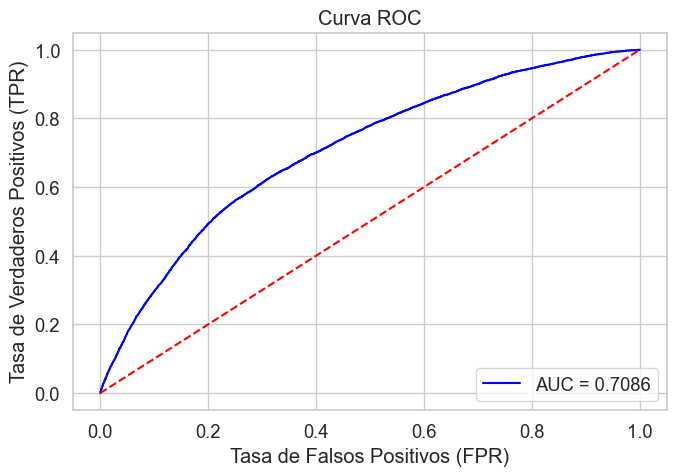

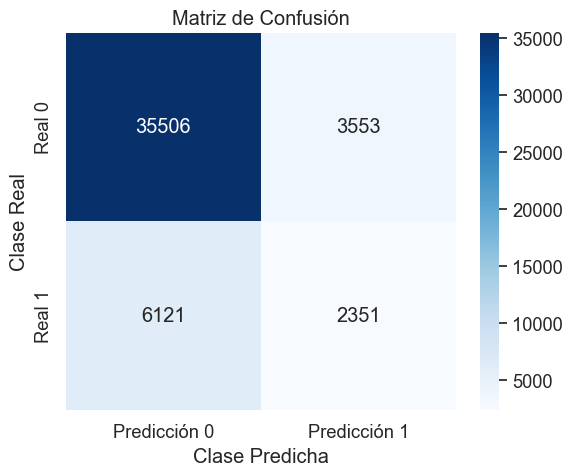

In [13]:
# -----------------------------------------------------
# 4. Generar los Gráficos
# -----------------------------------------------------
# Configuración general de los gráficos
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# a) Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# b) Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicción 0', 'Predicción 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.title('Matriz de Confusión')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()

## **CONCLUSIONES**

En esta versión del proyecto, hemos conseguido resultados claramente mejores que en las versiones anteriores. Esto se logró mediante la modificación de la estructura de la red neuronal recurrente y el ajuste del umbral de conversión de predicciones de probabilidad a clases binarias.

Es importante aclarar que, en este notebook, se presentan los resultados del entrenamiento del modelo utilizando el 10% de los datos. Sin embargo, el modelo fue entrenado con el dataset completo en otro ordenador con mayor poder computacional, lo cual permitió obtener mejores resultados.

A continuación, se presenta la matriz de confusión y las métricas de evaluación obtenidas:

### **Matriz de Confusión**

|            | Predicción 0 | Predicción 1 |
|------------|--------------|--------------|
| **Real 0** | 38,398       | 661          |
| **Real 1** | 7,542        | 930          |

### **Métricas de Evaluación**

| Métrica                  | Valor    |
|--------------------------|----------|
| Exactitud (Accuracy)     | 0.841388 |
| Precisión (Precision)    | 0.633469 |
| Sensibilidad (Recall)    | 0.241720 |
| F1-Score                 | 0.349918 |
| AUC-ROC                  | 0.849397 |

Estas métricas son el resultado del entrenamiento del modelo utilizando el dataset completo de compras (Buys).

Como parte de este proyecto, se incluirá una versión básica de la aplicación (ejecutor.py). Además, continuaremos mejorando el proyecto siguiendo la dinámica que hemos mantenido hasta ahora, buscando siempre implementar mejoras que nos acerquen al objetivo deseado. 
Nota: ejecutor.py trabaja con los modelos entrenados en otro computador. Es necesario considerar que hasta ahora usamos dos modelos independientes dedicados a compras y ventas respectivamente.
